In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bidi import algorithm as bidialg

from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, Dense, LeakyReLU, Dropout, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler

import pymongo
from pymongo import MongoClient

from subprocess import check_output

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

stocks = []
stocks.append('فاسمين')
stocks.append('شدوص')
stocks.append('خاذين')
stocks.append('خزر')
# stocks.append('حريل')
stocks.append('كگل')
stocks.append('چكارن')
stocks.append('كاما')
stocks.append('فملي')
stocks.append('فاذر')
stocks.append('فاراك')
stocks.append('خشرق')
stocks.append('تايرا')
stocks.append('فولاد')
stocks.append('شپنا')

fix_stocks = []
for val in stocks:
    fix_stocks.append(bidialg.get_display(val))

Using TensorFlow backend.


In [2]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query).sort([("date", pymongo.ASCENDING)])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']
    
    # df = df[['date', 'open', 'high', 'low', 'close']].rename(columns=str.capitalize)
    df = df[['date', 'vol', 'open', 'high', 'low', 'close']].rename(columns={'vol': 'volume'})
    
    def dateChange(y):
        x = str(y)
        return x[0:4] + '-' + x[4:6] + '-' + x[6:8]
    
    df['date'] = df['date'].apply(dateChange)
    return df

In [3]:
dfs = []
for x in stocks:
    df = read_mongo('bors', 'stock', query={ 'name': x }, username='bors', password='C26JntThhCAUGYPx')
    df.drop(['date'],1,inplace=True)
    dfs.append(df)

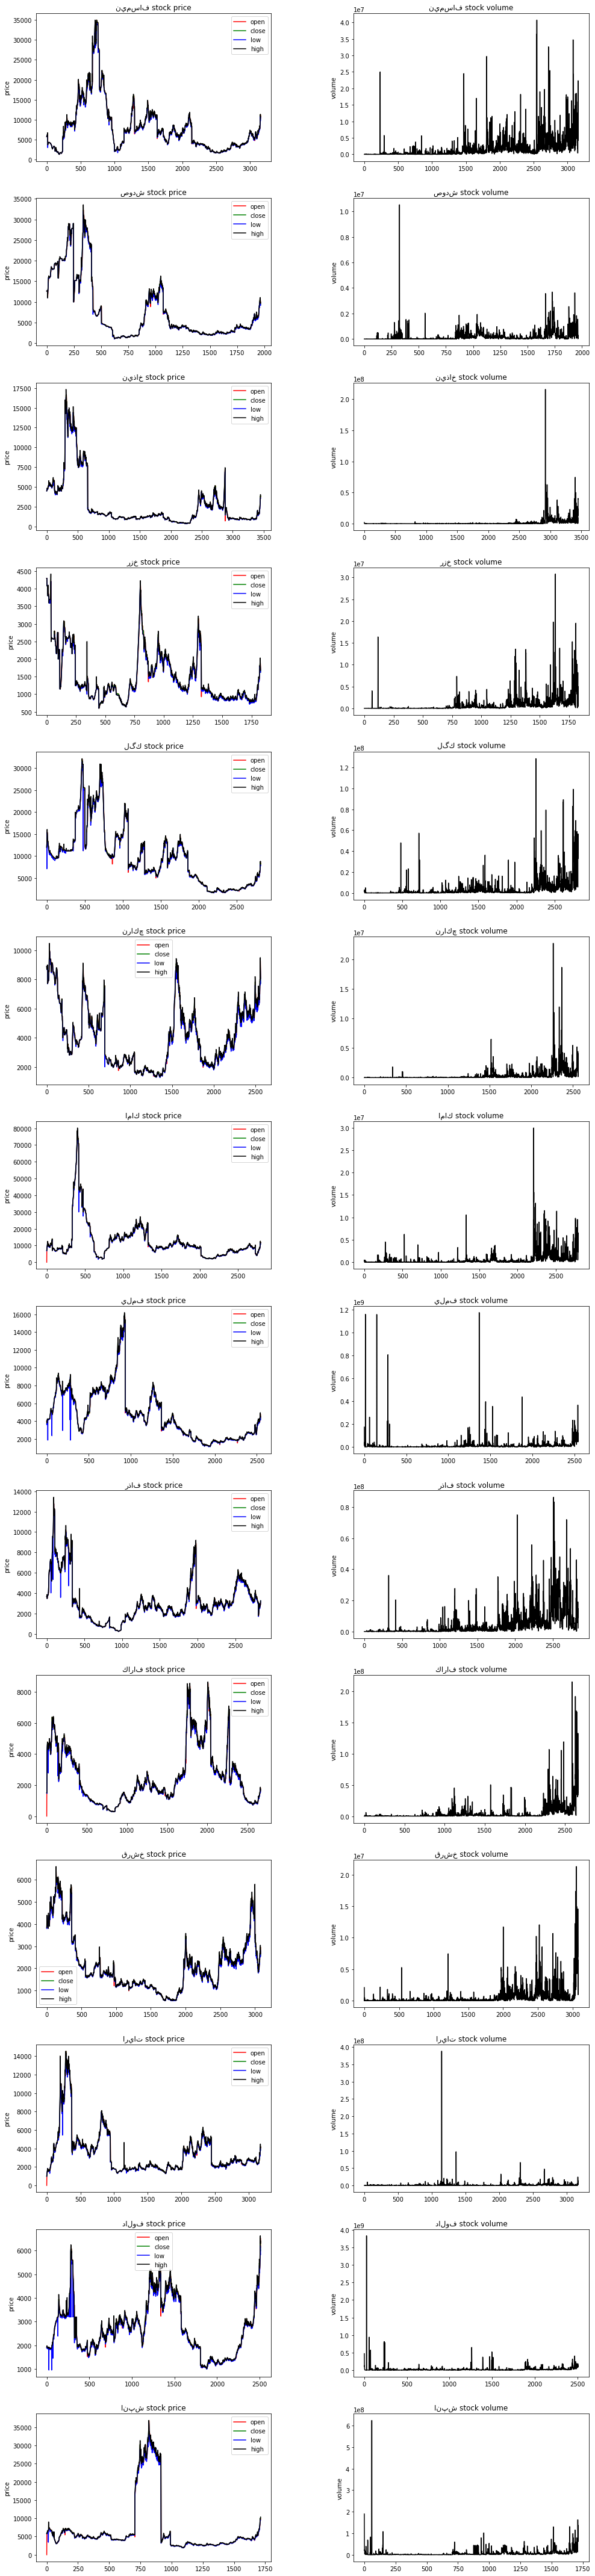

In [4]:
fix, axs = plt.subplots(len(stocks), 2, figsize=(15, 5 * len(stocks)));
for key in range(len(fix_stocks)):
    df = dfs[key]
    axs[key, 0].plot(df.open.values, color='red', label='open')
    axs[key, 0].plot(df.close.values, color='green', label='close')
    axs[key, 0].plot(df.low.values, color='blue', label='low')
    axs[key, 0].plot(df.high.values, color='black', label='high')
    axs[key, 0].set_title('%s stock price' % fix_stocks[key])
    axs[key, 0].set_ylabel('price')
    axs[key, 0].legend(loc='best')

    axs[key, 1].plot(df.volume.values, color='black', label='volume')
    axs[key, 1].set_title('%s stock volume' % fix_stocks[key])
    axs[key, 1].set_ylabel('volume')
#     axs[key, 1].legend(loc='best')
    
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [5]:
def windowed_norimilize(df):
    for j in cols:
        df[j] = df[j].astype(float)
        data = []
        for index in range(0, df.shape[0], seq_len):
            data[index:index + seq_len] = min_max_scaler.fit_transform(df[j][index:index + seq_len].values.reshape(-1,1))
        df[j] = data
    return df

def normalize_data(df):
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = close_scaler.fit_transform(df['close'].values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    return df

In [6]:
# function for min-max normalization of stock
min_max_scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
seq_len = 16 # choose sequence length (16 is 1 month)

# function to create train, validation, test data given stock data and sequence length
shift = 1

def smooth_data(dt, length):
    for i in range(len(cols)):
        EMA = 0.0
        gamma = 0.1
        for ti in range(length):
          EMA = gamma*dt[ti, i] + (1-gamma)*EMA
          dt[ti, i] = EMA
    return dt

def load_data(stock, target, seq_len):
    data_raw = stock.values # convert to numpy array
    data_len = len(data_raw) - seq_len
    
    train_perc = 100 - valid_set_size_percentage - test_set_size_percentage;
    train_set_size = int(np.round(train_perc / 100 * (data_len)))
    train_set_size = int(np.round(train_set_size / seq_len) * seq_len)
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data_len));  
    valid_set_size = int(np.ceil(valid_set_size / seq_len) * seq_len)
    test_set_size = data_len - (train_set_size + valid_set_size)
    
    smooth_size = train_set_size + seq_len + shift
    # smooth_size = smooth_size + valid_set_size
    
    # smooth target
    EMA = 0.0
    gamma = 0.1
    for ti in range(smooth_size):
      EMA = gamma*target[ti] + (1-gamma)*EMA
      target[ti] = EMA
    # smooth train and valid data
    data_raw = smooth_data(data_raw, smooth_size)
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    
    x_train = data[:train_set_size]
    y_train = target[seq_len + shift:train_set_size + seq_len + shift]
    yz_train = data_raw[seq_len + shift:train_set_size + seq_len + shift]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:]
    y_valid = target[train_set_size + seq_len + shift:train_set_size + valid_set_size + seq_len + shift]
    yz_valid = data_raw[train_set_size + seq_len + shift:train_set_size + valid_set_size + seq_len + shift]
    
    x_test = data[train_set_size + valid_set_size:]
    y_test = target[train_set_size + valid_set_size + seq_len + shift:]
    yz_test = data_raw[train_set_size + valid_set_size + seq_len + shift:]
    
    final_set_size = int(np.floor((data.shape[0] - seq_len) / seq_len) * seq_len)
    x_final = data[data.shape[0] - final_set_size:]
    
    return [x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final]

In [7]:
df_data = []
df_stock_norm = []
df_size = []
df_cols = []

for df in dfs:
    # save size of df
    df_stock = df
    size = df.shape[0]
    df_size.append(size)

    cols = list(df_stock.columns.values)
    df_cols.append(cols)

    # normalize stock
    stock_norm = df_stock.copy()
#     stock_norm = windowed_norimilize(stock_norm)
    stock_norm = normalize_data(stock_norm)
    # stock_norm.open[0]
    df_stock_norm.append(stock_norm)

    x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final = load_data(
        stock_norm, stock_norm['close'], seq_len)
    
    df_data.append((x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final))
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('yz_train.shape = ', yz_train.shape)
# print('x_valid.shape = ',x_valid.shape)
# print('y_valid.shape = ', y_valid.shape)
# print('yz_valid.shape = ', yz_valid.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ',y_test.shape)
# print('yz_test.shape = ',yz_test.shape)
# print('x_final.shape = ',x_final.shape)
# print('df.size = ',df_size)

/home/vahid/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


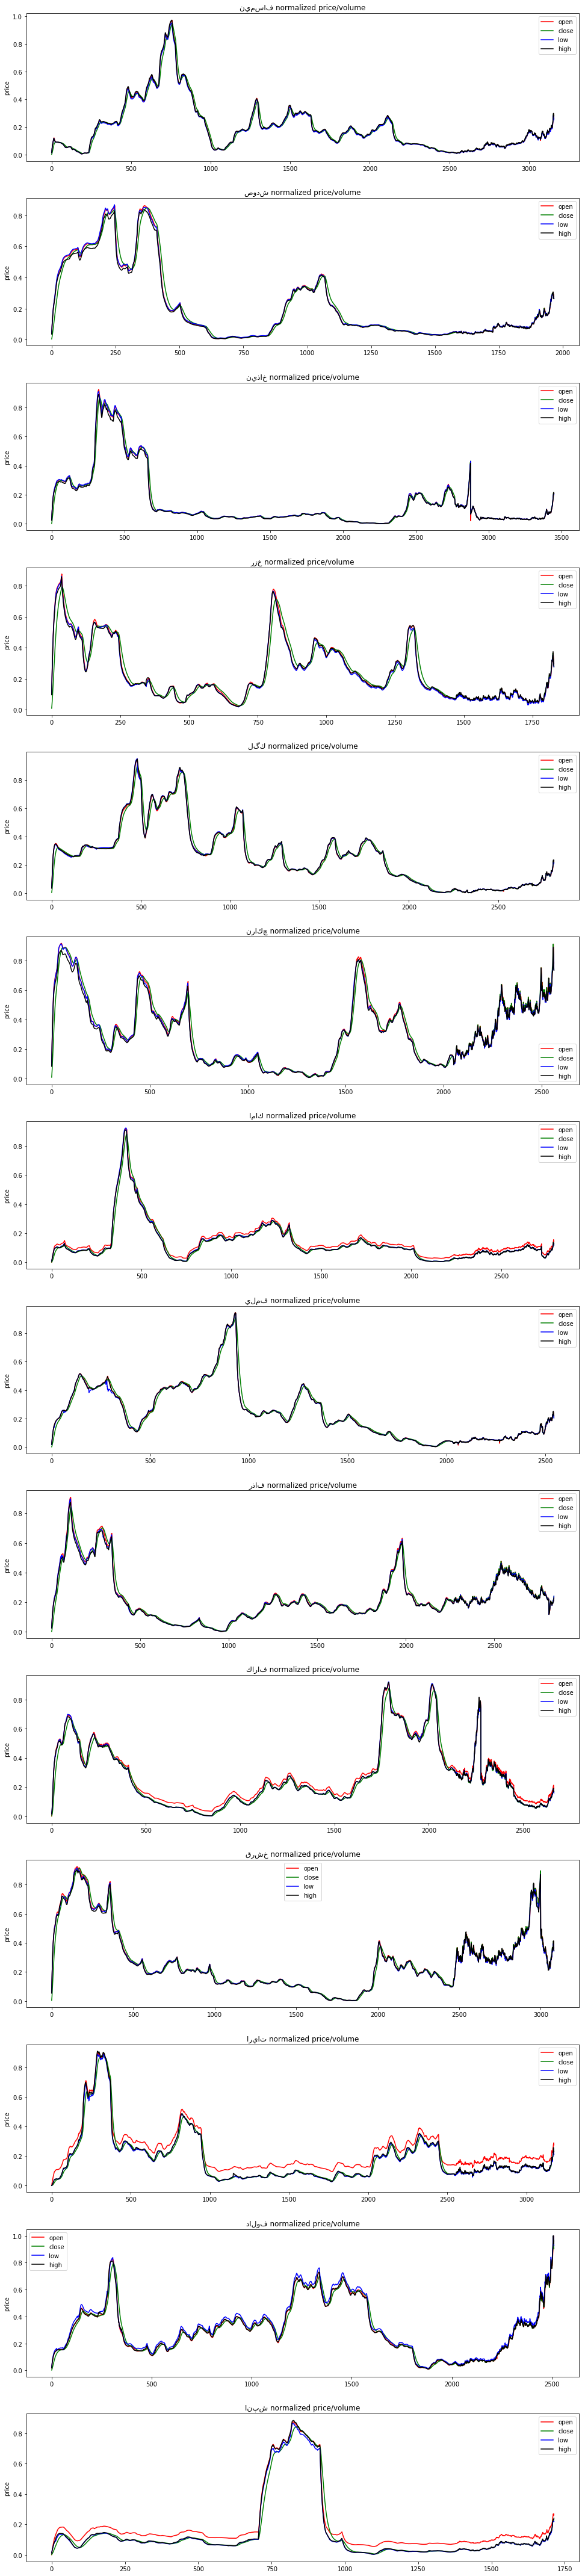

In [8]:
fix, axs = plt.subplots(len(stocks), 1, figsize=(15, 5 * len(stocks)));
for key in range(len(fix_stocks)):
    df = df_stock_norm[key]
    axs[key].plot(df.open.values, color='red', label='open')
    axs[key].plot(df.close.values, color='green', label='close')
    axs[key].plot(df.low.values, color='blue', label='low')
    axs[key].plot(df.high.values, color='black', label='high')
    axs[key].set_title('%s normalized price/volume' % fix_stocks[key])
    axs[key].set_ylabel('price')
    axs[key].legend(loc='best')
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## predict

In [9]:
models = []
epochs = 15
units = 50

for key in range(len(fix_stocks)):
    cols = df_cols[key]
    x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final = df_data[key]
    
    newModel = Sequential ()
    newModel.add (LSTM (units,
                        activation = 'tanh',
                        batch_input_shape = (seq_len, seq_len, len(cols)),
                        stateful=True,
                        batch_size=seq_len,
                        recurrent_activation = 'hard_sigmoid',
                        return_sequences=True,
                        input_shape =(seq_len, len(cols)) ))
    newModel.add(Dropout(0.2))
    newModel.add (LSTM (int(units * 2),
                        activation = 'tanh',
                        batch_input_shape = (seq_len, seq_len, len(cols)),
                        stateful=True,
                        return_sequences=False,
                        batch_size=seq_len,
                        recurrent_activation = 'hard_sigmoid',
                        input_shape =(seq_len, len(cols)) ))
    newModel.add(Dropout(0.2))
    # newModel.add(Dense (units = 1, activation='linear'))
    # newModel.add(Flatten())
    newModel.add(Dense (units = len(cols)))
    newModel.compile (loss ="mse" , optimizer = "adam") 

    print('Train data of %s' % stocks[key])
    newModel.fit(x_train, yz_train, batch_size = seq_len, validation_data=(x_valid, yz_valid), epochs = epochs)
    newModel.reset_states()
    
    models.append(newModel)

Train data of فاسمين
Train on 2512 samples, validate on 320 samples
Epoch 1/15
2512/2512 [==============================] - 3s 1ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 2/15
2512/2512 [==============================] - 2s 752us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 3/15
2512/2512 [==============================] - 2s 742us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 4/15
2512/2512 [==============================] - 2s 751us/step - loss: 9.6592e-04 - val_loss: 0.0028
Epoch 5/15
2512/2512 [==============================] - 2s 739us/step - loss: 7.7714e-04 - val_loss: 0.0026
Epoch 6/15
2512/2512 [==============================] - 2s 739us/step - loss: 6.0862e-04 - val_loss: 0.0027
Epoch 7/15
2512/2512 [==============================] - 2s 751us/step - loss: 5.9390e-04 - val_loss: 0.0026
Epoch 8/15
2512/2512 [==============================] - 2s 758us/step - loss: 5.1588e-04 - val_loss: 0.0027
Epoch 9/15
2512/2512 [==============================] - 2s 753us/step - loss: 4.82

Epoch 14/15
2240/2240 [==============================] - 2s 763us/step - loss: 5.7855e-04 - val_loss: 7.7072e-04
Epoch 15/15
2240/2240 [==============================] - 2s 750us/step - loss: 5.0509e-04 - val_loss: 7.8139e-04
Train data of چكارن
Train on 2032 samples, validate on 256 samples
Epoch 1/15
2032/2032 [==============================] - 3s 1ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 2/15
2032/2032 [==============================] - 2s 753us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 3/15
2032/2032 [==============================] - 2s 751us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 4/15
2032/2032 [==============================] - 2s 748us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 5/15
2032/2032 [==============================] - 2s 774us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 6/15
2032/2032 [==============================] - 2s 764us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 7/15
2032/2032 [==============================] - 2s 746us/step - loss: 8.8978e

Epoch 12/15
2112/2112 [==============================] - 2s 757us/step - loss: 5.8238e-04 - val_loss: 0.0039
Epoch 13/15
2112/2112 [==============================] - 2s 760us/step - loss: 5.7076e-04 - val_loss: 0.0041
Epoch 14/15
2112/2112 [==============================] - 2s 766us/step - loss: 5.3536e-04 - val_loss: 0.0038
Epoch 15/15
2112/2112 [==============================] - 2s 754us/step - loss: 5.1709e-04 - val_loss: 0.0038
Train data of خشرق
Train on 2448 samples, validate on 320 samples
Epoch 1/15
2448/2448 [==============================] - 4s 1ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 2/15
2448/2448 [==============================] - 2s 758us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 3/15
2448/2448 [==============================] - 2s 753us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 4/15
2448/2448 [==============================] - 2s 756us/step - loss: 9.6160e-04 - val_loss: 0.0022
Epoch 5/15
2448/2448 [==============================] - 2s 753us/step - loss: 9.

In [10]:
future_days_predict = seq_len
close_index = 4

futures = []
last_steps = []

def create_batch(step):
    data = []
    for index in range(len(step) - seq_len): 
        data.append(step[index: index + seq_len])
    return np.array(data)

def get_close(dt):
    data = []
    for x in dt:
        data.append(x[close_index])
    return data

def close_normal(dt):
    data = []
    for x in dt:
        data.append([x])
    return data

for key in range(len(fix_stocks)):
    cols = df_cols[key]
    x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final = df_data[key]
    newModel = models[key]

    predictions = newModel.predict(x_final, batch_size=seq_len) #this creates states
    close_predictions = predictions
    last_step = predictions

    future = []
    p_future = []
    currentStep = create_batch(predictions) #last step from the previous prediction

    step = 0
    for i in range(future_days_predict):
        currentStep = newModel.predict(currentStep, batch_size=seq_len) #get the next step
        future.append(currentStep) #store the future steps  
        last_step = currentStep
        p_future.append(currentStep[-1,4])
        currentStep = create_batch(currentStep)
        step = step + 1
        print('step ' + str(step) + ' for %s is done' % stocks[key])

    #after processing a sequence, reset the states for safety
    newModel.reset_states()
    
    last_steps.append(last_step)
    futures.append(p_future)

step 1 for فاسمين is done
step 2 for فاسمين is done
step 3 for فاسمين is done
step 4 for فاسمين is done
step 5 for فاسمين is done
step 6 for فاسمين is done
step 7 for فاسمين is done
step 8 for فاسمين is done
step 9 for فاسمين is done
step 10 for فاسمين is done
step 11 for فاسمين is done
step 12 for فاسمين is done
step 13 for فاسمين is done
step 14 for فاسمين is done
step 15 for فاسمين is done
step 16 for فاسمين is done
step 1 for شدوص is done
step 2 for شدوص is done
step 3 for شدوص is done
step 4 for شدوص is done
step 5 for شدوص is done
step 6 for شدوص is done
step 7 for شدوص is done
step 8 for شدوص is done
step 9 for شدوص is done
step 10 for شدوص is done
step 11 for شدوص is done
step 12 for شدوص is done
step 13 for شدوص is done
step 14 for شدوص is done
step 15 for شدوص is done
step 16 for شدوص is done
step 1 for خاذين is done
step 2 for خاذين is done
step 3 for خاذين is done
step 4 for خاذين is done
step 5 for خاذين is done
step 6 for خاذين is done
step 7 for خاذين is done
step 8 for 

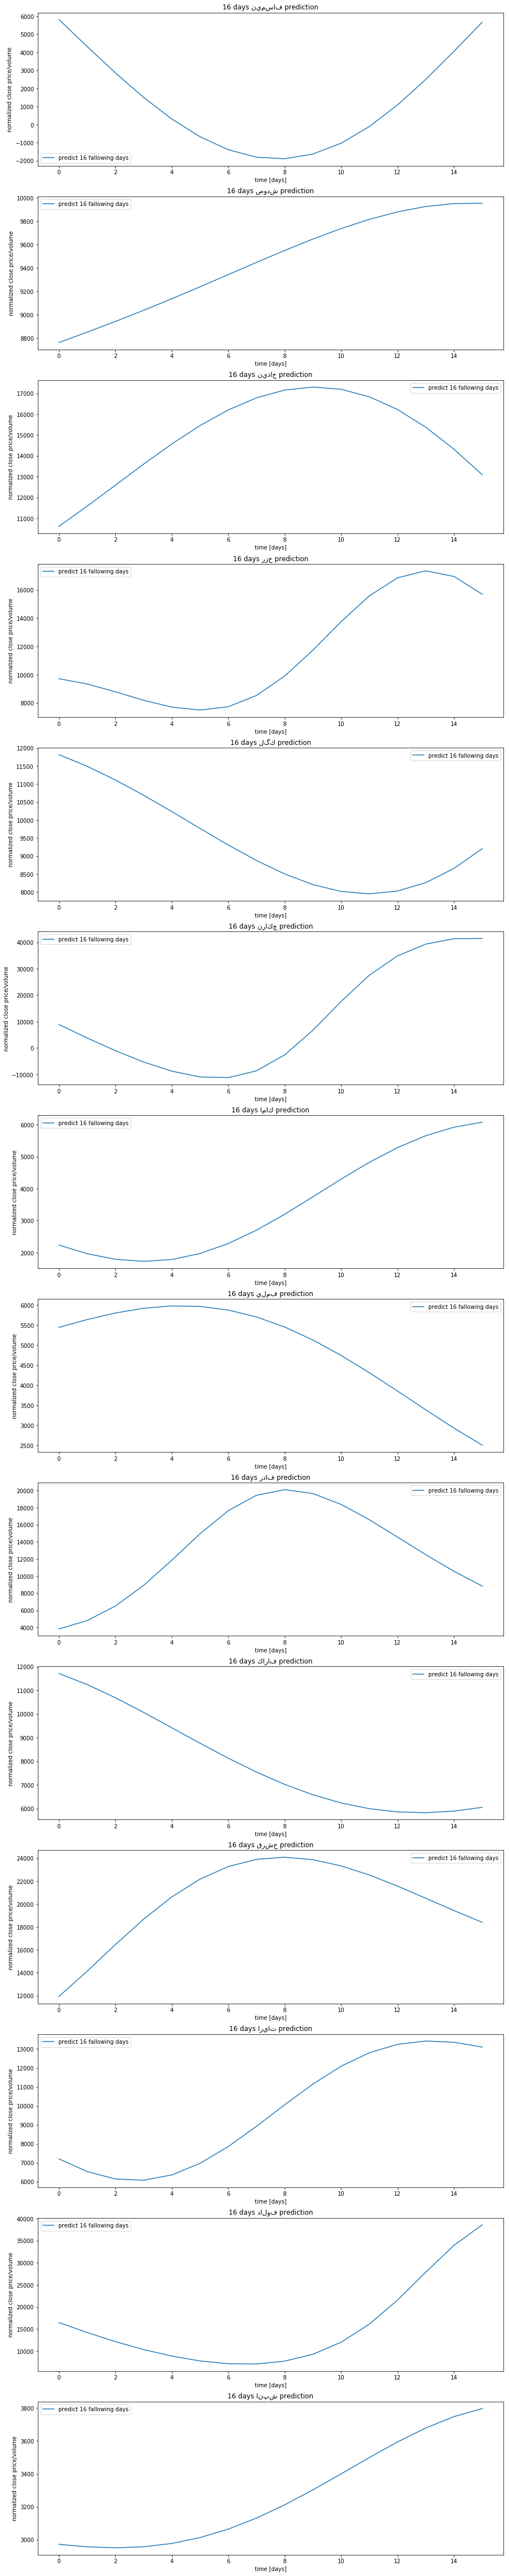

In [11]:
normilizescalar = MinMaxScaler()

fix, axs = plt.subplots(len(stocks), 1, figsize=(15, 6 * len(stocks)));
for key in range(len(fix_stocks)):
    cols = df_cols[key]
    x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final = df_data[key]
    p_future = futures[key]
    last_step = last_steps[key]

    p_f = np.array(p_future)

    fx1_close = np.array(last_step)
    fx1_close = fx1_close[len(fx1_close) - future_days_predict:,4]

    axs[key].plot(close_scaler.inverse_transform(close_normal(fx1_close)), label='predict 16 fallowing days')
#     axs[key].plot(normilizescalar.fit_transform(close_normal(fx1_close)), label='predict 16 fallowing days')
#     axs[key].plot(close_scaler.inverse_transform(close_normal(p_f)), label='predict 16 days by parameter')
    axs[key].set_title('16 days %s prediction' % fix_stocks[key])
    axs[key].set_xlabel('time [days]')
    axs[key].set_ylabel('normalized close price/volume')
    axs[key].legend(loc='best')

plt.show()

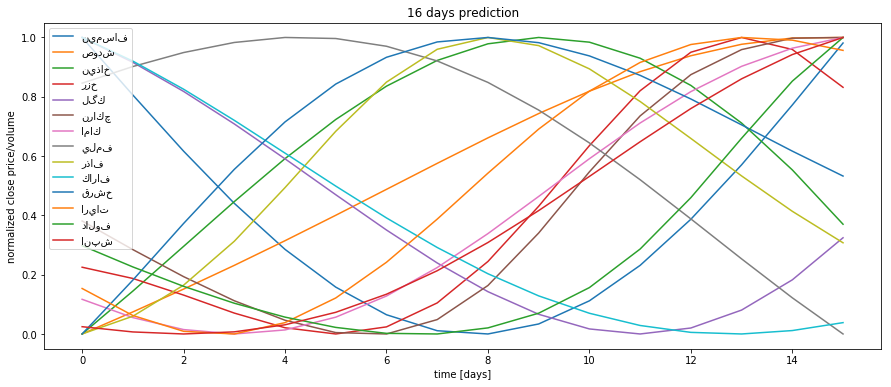

In [12]:
plt.figure(figsize=(15, 6));
for key in range(len(fix_stocks)):
    cols = df_cols[key]
    x_train, y_train, yz_train, x_valid, y_valid, yz_valid, x_test, y_test, yz_test, x_final = df_data[key]
    p_future = futures[key]
    last_step = last_steps[key]

    p_f = np.array(p_future)
    fx1_close = np.array(last_step)
    fx1_close = fx1_close[len(fx1_close) - future_days_predict:,4]

    plt.plot(normilizescalar.fit_transform(close_normal(fx1_close)), label='%s' % fix_stocks[key])
    
plt.title('16 days prediction')
plt.xlabel('time [days]')
plt.ylabel('normalized close price/volume')
plt.legend(loc='best')
plt.show()